Using TensorFlow backend.


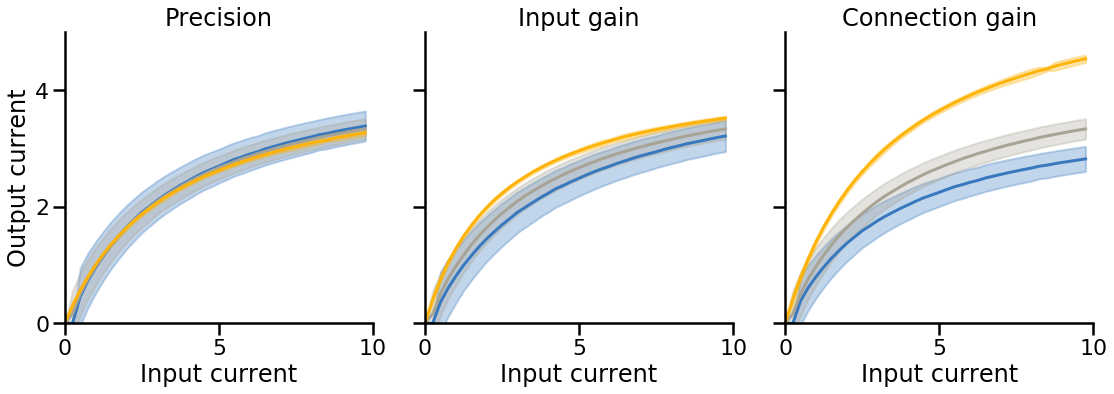

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from asn.conversion.utils import transfer_avgPSP, normalize_transfer

class ASN:
    """ Adaptive spiking neuron class, double-checked on Jan 24, 2018 """

    def __init__(self, mf=0.1, bias=0, input_gain=1, output_gain=1):
        # Params
        # membrane filter
        self.tau_phi = 2.5
        self.dPhi = np.exp(-1 / self.tau_phi)
        # threshold decay filter
        self.tau_gamma = 15.0
        self.dGamma = np.exp(-1 / self.tau_gamma)
        # refractory decay  filter
        self.tau_eta = 50.0
        self.dEta = np.exp(-1 / self.tau_eta)
        self.dBeta = self.dEta

        self.m_f = mf  # **2 would be the old matlab code
        self.theta0 = self.m_f  # Resting threshold

        self.S_bias = bias
        self.S = self.S_bias  # filtered activation, initialized with bias
        self.S_dyn = 0
        self.theta = self.theta0  # Start value of threshold
        self.theta_dyn = 0  # dynamic part of the threshold
        self.S_hat = 0  # refractory response, internal approximation

        self.current_next = 0  # incoming current in next neuron
        self.S_next = 0  # and filtered by the membrane potential.
        self.I = 0
        self.spike = 0

        self.input_gain = input_gain
        self.output_gain = output_gain

    def update(self, current, spike_train=True):
        """inject current for one moment at a time"""
        # Membrane filter
        if spike_train:
            self.I = self.I * self.dBeta + current
        else:
            self.I = current
        self.S_dyn = (1 - self.dPhi) * self.I * self.input_gain + self.dPhi * self.S_dyn
        self.S = self.S_bias + self.S_dyn
        # Decay
        self.S_hat = self.S_hat * self.dEta
        self.current_next = self.current_next * self.dEta
        # Spike?
        if self.S - self.S_hat > 0.5 * self.theta:
            self.spike = 1  # Code spike

            # Update refractory response
            self.S_hat = self.S_hat + self.theta

            # Update threshold
            # self.theta_dyn = self.theta_dyn + self.m_f*self.theta/self.theta0 #based on the matlab code
            self.theta_dyn = self.theta_dyn + self.m_f * self.theta  # adaptive part based on the paper

            self.current_next = self.current_next + 1 * self.output_gain
        else:
            self.spike = 0

        # Decay
        self.theta_dyn = self.theta_dyn * self.dGamma
        self.theta = self.theta0 + self.theta_dyn

        # Signal in next neuron
        self.S_next = (1 - self.dPhi) * self.current_next + self.dPhi * self.S_next

    def call(self, input, spike_train=True, mf=0.1, bias=0, input_gain=1, output_gain=1):
        timesteps = input.shape[1]
        batch_size = input.shape[0]
        S = np.zeros(input.shape)
        S_next = np.zeros(input.shape)
        spikes = np.zeros(input.shape)
        S_hat = np.zeros(input.shape)
        theta = np.zeros(input.shape)

        for b in range(batch_size):
            self.__init__(mf=mf, bias=bias, input_gain= input_gain, output_gain= output_gain)
            for t in range(timesteps):  # loop over timesteps
                self.update(input[b, t, :], spike_train=spike_train)
                S[b, t, 0] = self.S
                S_next[b, t, 0] = self.S_next
                spikes[b, t, 0] = self.spike
                S_hat[b, t, 0] = self.S_hat
                theta[b, t, 0] = self.theta

        return S_next, spikes, S, S_hat, theta


figure_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN_2020/Figures/'
save = False

colors = sns.color_palette(sns.xkcd_palette(["windows blue", "greyish", "amber", "ocean blue", "orange", "moss", "dusty purple"]))
sns.set_context("poster")

time_steps = 750
start_eval = 250
# Approximation process

neutral_mf = 0.45
high_mf = 0.1
low_mf = 0.55

mfs = [0.6, 0.45, 0.1]
conds = ['Precision', 'Input gain', 'Connection gain']

currents = (np.arange(0,10, 0.25)[:, np.newaxis] * np.ones((1, time_steps)))[:,:, np.newaxis]

means= np.zeros((len(conds), len(mfs), currents.shape[0]))
var = np.zeros((len(conds), len(mfs), currents.shape[0]))
fig, ax = plt.subplots(1,3, figsize=(16,6), sharey=True)
ax = ax.flatten()
for c, cond in enumerate(conds):

    for m, mf in enumerate(mfs):
        neuron = ASN(mf=mf)

        if cond =='Input gain':
            input_gain = ((mf - 0.45)/ -0.45) * 0.5 + 1
            output_gain = 1
        elif cond =='Connection gain':
            output_gain =((mf - 0.45)/ -0.45) * 0.5 + 1
            input_gain = 1
        else:
            output_gain = 1
            input_gain = 1
            
        S_next, spikes, S, S_hat, theta = neuron.call(currents, spike_train=False, mf=mf, input_gain=input_gain,
                                                      output_gain=output_gain)
        S_next = S_next * normalize_transfer(mf)
        ax[c].plot(currents[:,0,0], np.mean(S_next[:, start_eval:], axis=1), color = colors[m])
        ax[c].fill_between(currents[:,0,0], (np.mean(S_next[:, start_eval:], axis=1) - 3 * np.std(S_next[:, start_eval:], axis=1)).flatten(),
                         (np.mean(S_next[:, start_eval:], axis=1) + 3 * np.std(S_next[:, start_eval:], axis=1)).flatten(),
                         alpha=0.3, color=colors[m])

        sns.despine(ax=ax[c])
        means[c,m,:] = np.mean(S_next[:, start_eval:], axis=1).flatten()
        var[c, m, :] = np.var(S_next[:, start_eval:], axis=1).flatten()
        #plt.fill_between(currents[:,0,0], (np.mean(S_next[:, start_eval:], axis=1) - np.std(S_next[:, start_eval:], axis=1)).flatten(),
        #                 (np.mean(S_next[:, start_eval:], axis=1) + np.std(S_next[:, start_eval:], axis=1)).flatten(),
        #                 alpha=0.5, color=colors[m])
    ax[c].set_title(cond)
    ax[c].set_xlabel('Input current')
    ax[c].set_ylim([0,5])
    ax[c].set_yticks([0,2,4])
    ax[c].set_xlim([0,10])
    ax[c].set_xticks([0, 5, 10])
    if c == 0:
        ax[c].set_ylabel('Output current')

plt.tight_layout()
if save == True:
    fig.savefig(figure_path + 'TransferCurves.pdf', dpi=300, transparent=True)
else:
    fig.show()

